# Copy Task Plots

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
sys.path.append(os.path.abspath(os.getcwd() + "./../"))

%matplotlib inline

## Load training history

To generate the models and training history used in this notebook, run the following commands:

```
mkdir ./notebooks/copy
./train.py --seed 1 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 10 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 100 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 1000 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
```

In [2]:
batch_num = 40000
files = glob("./copy/*-{}.json".format(batch_num))
files

['./copy\\copy-task-1-batch-40000.json',
 './copy\\copy-task-10-batch-40000.json',
 './copy\\copy-task-100-batch-40000.json',
 './copy\\copy-task-1000-batch-40000.json']

In [3]:
# Read the metrics from the .json files
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print("Training history (seed x metric x sequence) =", training.shape)

Training history (seed x metric x sequence) = (4, 3, 40000)


In [4]:
# Average every dv values across each (seed, metric)
dv = 1000
training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
print(training.shape)

(4, 3, 40)


In [5]:
# Average the seeds
training_mean = training.mean(axis=0)
training_std = training.std(axis=0)
print(training_mean.shape)
print(training_std.shape)

(3, 40)
(3, 40)


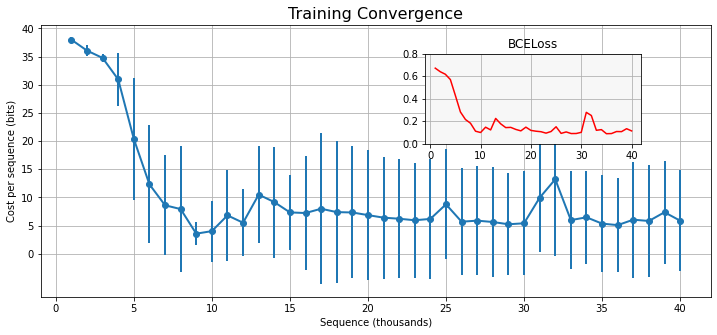

In [6]:
fig = plt.figure(figsize=(12, 5))

# X axis is normalized to thousands
x = np.arange(dv / 1000, (batch_num / 1000) + (dv / 1000), dv / 1000)

# Plot the cost
# plt.plot(x, training_mean[0], 'o-', linewidth=2, label='Cost')
plt.errorbar(x, training_mean[0], yerr=training_std[0], fmt='o-', elinewidth=2, linewidth=2, label='Cost')
plt.grid()
plt.yticks(np.arange(0, training_mean[0][0]+5, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Sequence (thousands)')
plt.title('Training Convergence', fontsize=16)

ax = plt.axes([.57, .55, .25, .25], facecolor=(0.97, 0.97, 0.97))
plt.title("BCELoss")
plt.plot(x, training_mean[1], 'r-', label='BCE Loss')
plt.yticks(np.arange(0, training_mean[1][0]+0.2, 0.2))
plt.grid()

plt.show()

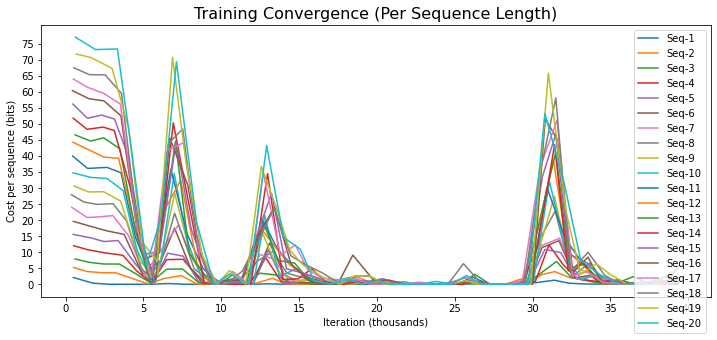

In [7]:
loss = history[3]['loss']
cost = history[3]['cost']
seq_lengths = history[3]['seq_lengths']

unique_sls = set(seq_lengths)
all_metric = list(zip(range(1, batch_num+1), seq_lengths, loss, cost))

fig = plt.figure(figsize=(12, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Iteration (thousands)')
plt.title('Training Convergence (Per Sequence Length)', fontsize=16)

for sl in unique_sls:
    sl_metrics = [i for i in all_metric if i[1] == sl]

    x = [i[0] for i in sl_metrics]
    y = [i[3] for i in sl_metrics]
    
    num_pts = len(x) // 50
    total_pts = num_pts * 50
    
    x_mean = [i.mean()/1000 for i in np.split(np.array(x)[:total_pts], num_pts)]
    y_mean = [i.mean() for i in np.split(np.array(y)[:total_pts], num_pts)]
    
    plt.plot(x_mean, y_mean, label='Seq-{}'.format(sl))

plt.yticks(np.arange(0, 80, 5))
plt.legend(loc=0)
plt.show()

# Evaluate

In [9]:
!pip3 install argcomplete

  Using cached argcomplete-1.12.3-py2.py3-none-any.whl (38 kB)


In [8]:
import torch
from IPython.display import Image as IPythonImage
from PIL import Image, ImageDraw, ImageFont
import io
from tasks.copytask import dataloader
from train import evaluate

In [9]:
from tasks.copytask import CopyTaskModelTraining
model = CopyTaskModelTraining()

In [10]:
model.net.load_state_dict(torch.load("./copy/copy-task-10-batch-40000.model"))

<All keys matched successfully>

In [11]:
seq_len = 60
_, x, y = next(iter(dataloader(1, 1, 8, seq_len, seq_len)))
result = evaluate(model.net, model.criterion, x, y)
y_out = result['y_out']

C:\Users\Akshay\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [12]:
def cmap(value):
    pixval = value * 255
    low = 64
    high = 240
    factor = (255 - low - (255-high)) / 255
    return int(low + pixval * factor)

def draw_sequence(y, u=12):
    seq_len = y.size(0)
    seq_width = y.size(2)
    inset = u // 8
    pad = u // 2
    width = seq_len * u + 2 * pad
    height = seq_width * u + 2 * pad
    im = Image.new('L', (width, height))
    draw = ImageDraw.ImageDraw(im)
    draw.rectangle([0, 0, width, height], fill=250)
    for i in range(seq_len):
        for j in range(seq_width):
            val = 1 - y[i, 0, j].data
            draw.rectangle([pad + i*u + inset,
                            pad + j*u + inset,
                            pad + (i+1)*u - inset,
                            pad + (j+1)*u - inset], fill=cmap(val))

    return im

def im_to_png_bytes(im):
    png = io.BytesIO()
    im.save(png, 'PNG')
    return bytes(png.getbuffer())

def im_vconcat(im1, im2, pad=8):
    assert im1.size == im2.size
    w, h = im1.size

    width = w
    height = h * 2 + pad

    im = Image.new('L', (width, height), color=255)
    im.paste(im1, (0, 0))
    im.paste(im2, (0, h+pad))
    return im

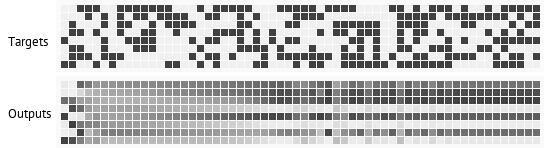

In [13]:
def make_eval_plot(y, y_out, u=12):
    im_y = draw_sequence(y, u)
    im_y_out = draw_sequence(y_out, u)
    im = im_vconcat(im_y, im_y_out, u//2)
    
    w, h = im.size
    pad_w = u * 7
    im2 = Image.new('L', (w+pad_w, h), color=255)
    im2.paste(im, (pad_w, 0))
    
    # Add text
    font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
    draw = ImageDraw.ImageDraw(im2)
    draw.text((u,4*u), "Targets", font=font)
    draw.text((u,13*u), "Outputs", font=font)
    
    return im2

im = make_eval_plot(y, y_out, u=8)
IPythonImage(im_to_png_bytes(im))

## Create an animated GIF

Lets see how the prediction looks like in each checkpoint that we saved. 

In [14]:
seq_len = 80
_, x, y = next(iter(dataloader(1, 1, 8, seq_len, seq_len)))

frames = []
font = ImageFont.truetype("./fonts/PT_Sans-Web-Regular.ttf", 13)
for batch_num in range(500, 10500, 500):
    model = CopyTaskModelTraining()
    model.net.load_state_dict(torch.load("./copy/copy-task-10-batch-{}.model".format(batch_num)))
    result = evaluate(model.net, model.criterion, x, y)
    y_out = result['y_out']
    frame = make_eval_plot(y, y_out, u=10)
    
    w, h = frame.size
    frame_seq = Image.new('L', (w, h+40), color=255)
    frame_seq.paste(frame, (0, 40))
    
    draw = ImageDraw.ImageDraw(frame_seq)
    draw.text((10, 10), "Sequence Num: {} (Cost: {})".format(batch_num, result['cost']), font=font)
    
    frames += [frame_seq]

In [15]:
im = frames[0]
im.save("./copy-train-80.gif", save_all=True, append_images=frames[1:], loop=0, duration=1000)

im = frames[0]
im.save("./copy-train-80-fast.gif", save_all=True, append_images=frames[1:], loop=0, duration=100)